## Imports and Seed

In [1]:
# imports
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import joblib

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Hyperparams of the competition

In [3]:
c_telescope = 1152
sbm_telescope = int(1152*0.75)  #864

## Import and Inspect the Raw Data

In [4]:
# import the data from csv file using pandas

dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.info()

(68528, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


<AxesSubplot:>

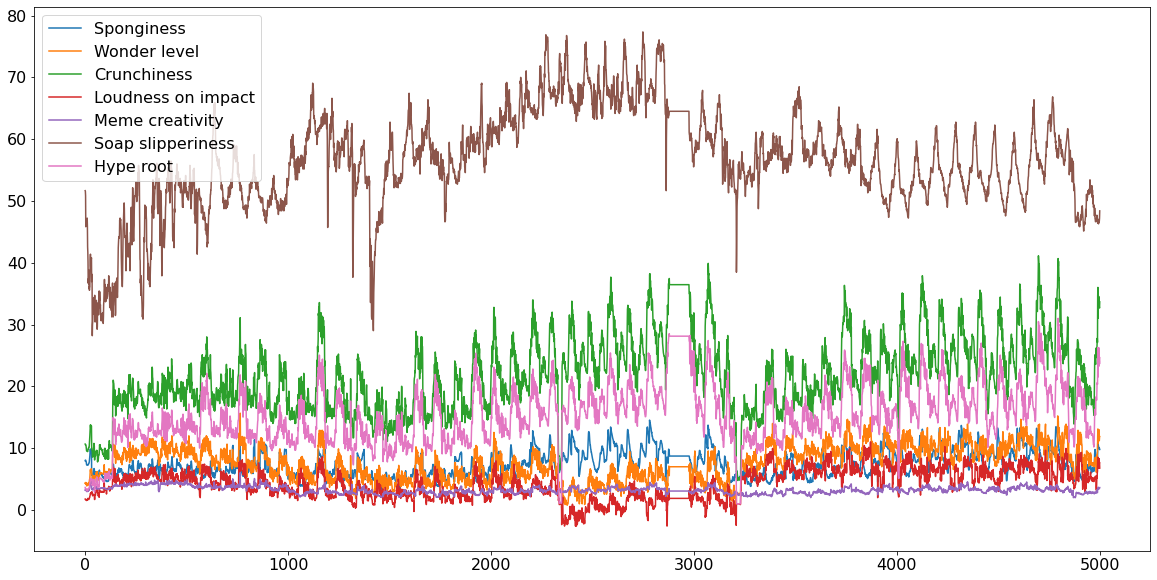

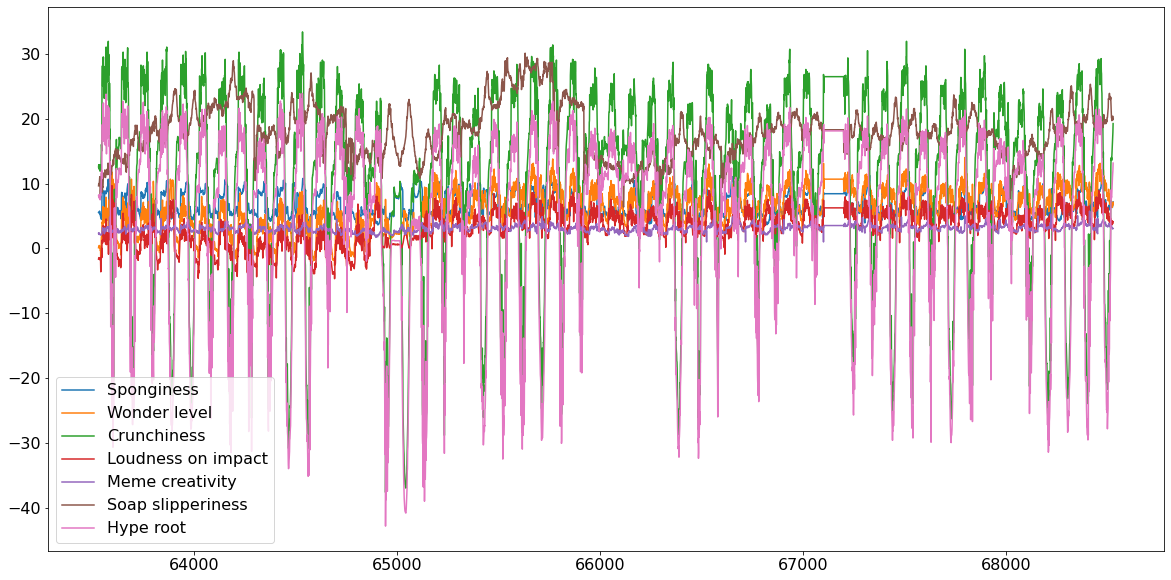

In [5]:
dataset.head(5000).plot.line( figsize=(20,10))
dataset.tail(5000).plot.line( figsize=(20,10))

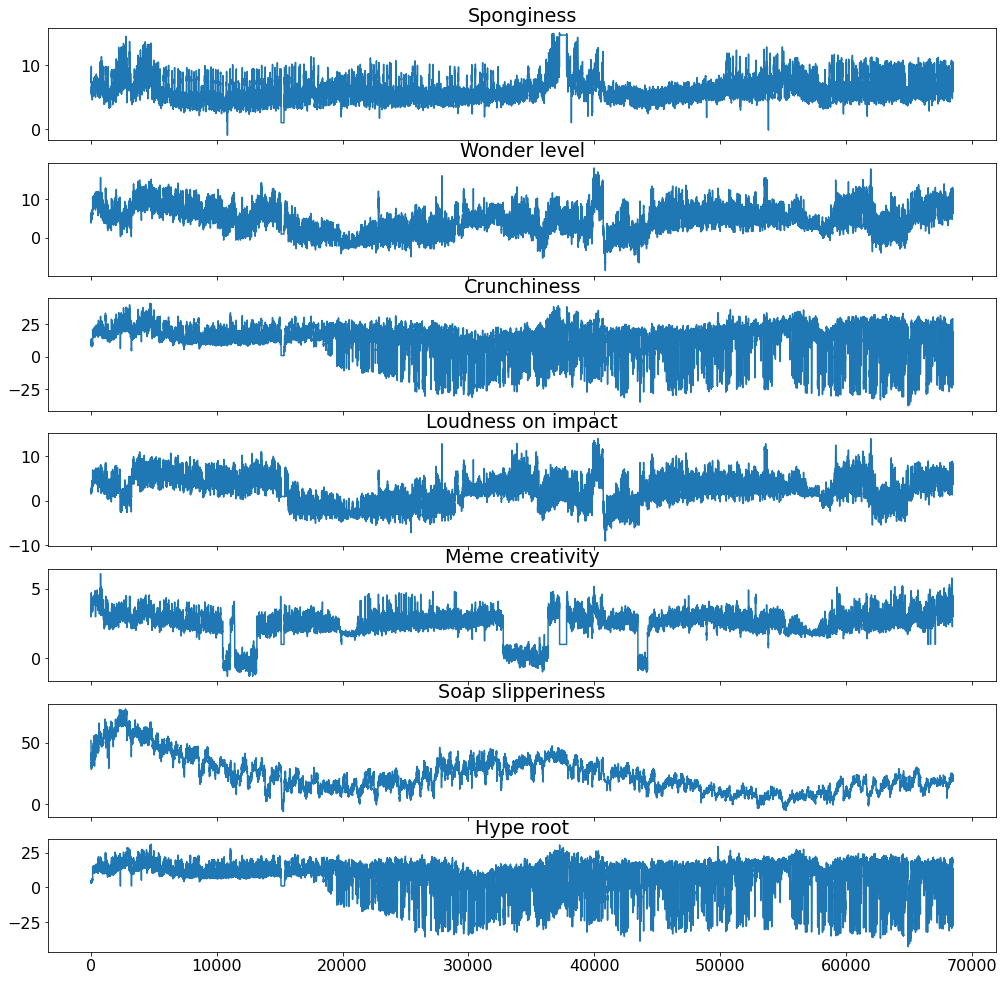

In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(
        len(columns),
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe(dataset, dataset.columns)


## Preprocess the data

In [7]:
# split into test and training datasets
test_size = int(dataset.shape[0]//10) # size of the test set is 10% of the training

X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

In [8]:
#normalize the data

# choice of scaler
scaler = MinMaxScaler()

# fitting the scaler
scaler.fit(X_train_raw)

#transform X_train_raw and X_test_raw
X_pp_train = scaler.transform(X_train_raw)
X_pp_test = scaler.transform(X_test_raw)

# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting
data = np.concatenate((X_pp_train,X_pp_test))
data = pd.DataFrame(data, columns = dataset.columns)
X_pp_train = data.iloc[:-test_size]
X_pp_test = data.iloc[-test_size:]

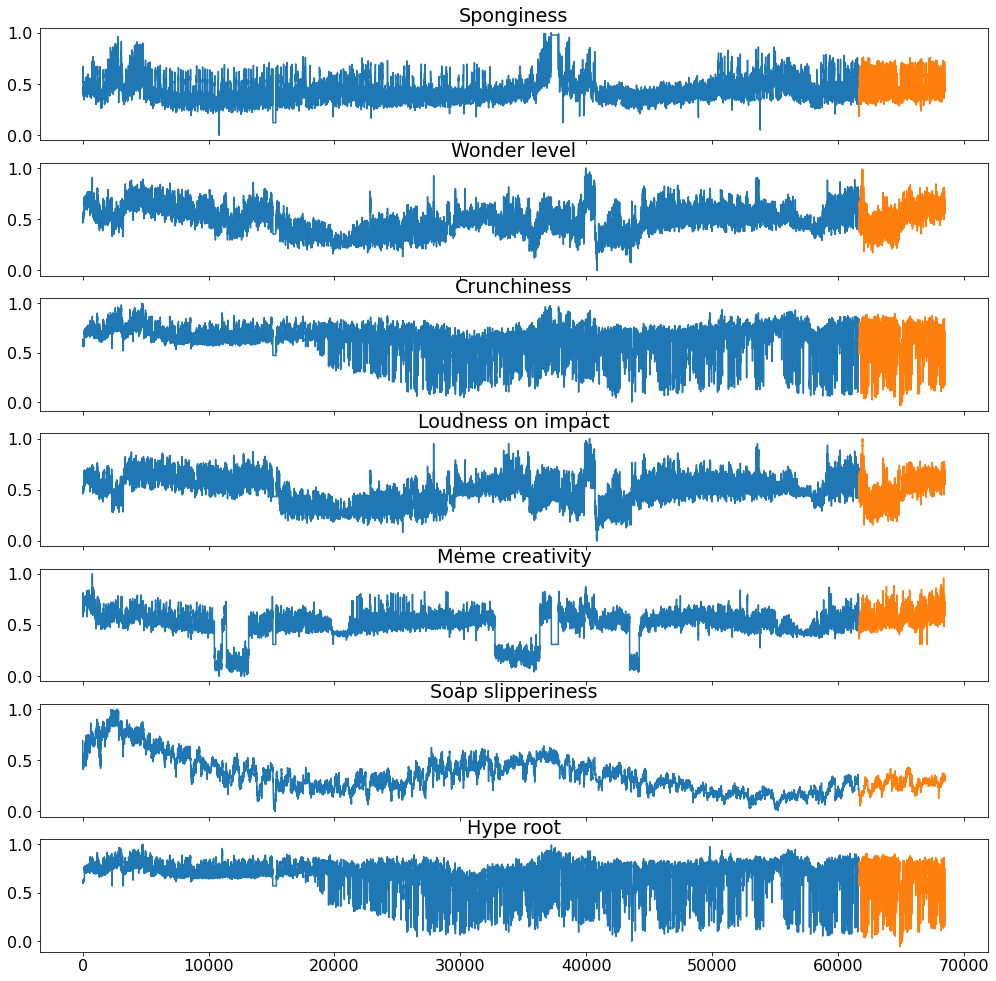

In [9]:
def plot_norm_data(arr1, arr2, columns):
    assert arr1.shape[1] == arr2.shape[1]
    figs, axs = plt.subplots(
        arr1.shape[1],
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(arr1.iloc[:, i])
        axs[i].plot(arr2.iloc[:, i])
        axs[i].set_title(col)
    plt.show()
plot_norm_data(X_pp_train, X_pp_test, dataset.columns)

In [10]:
# save the scaler
scaler_dir = 'vars\\scalers'
if not os.path.exists(scaler_dir):
    os.makedirs(scaler_dir)

scaler_path = os.path.join(scaler_dir, 'min_max_scaler.gz')
joblib.dump(scaler, scaler_path)

['vars\\scalers\\min_max_scaler.gz']

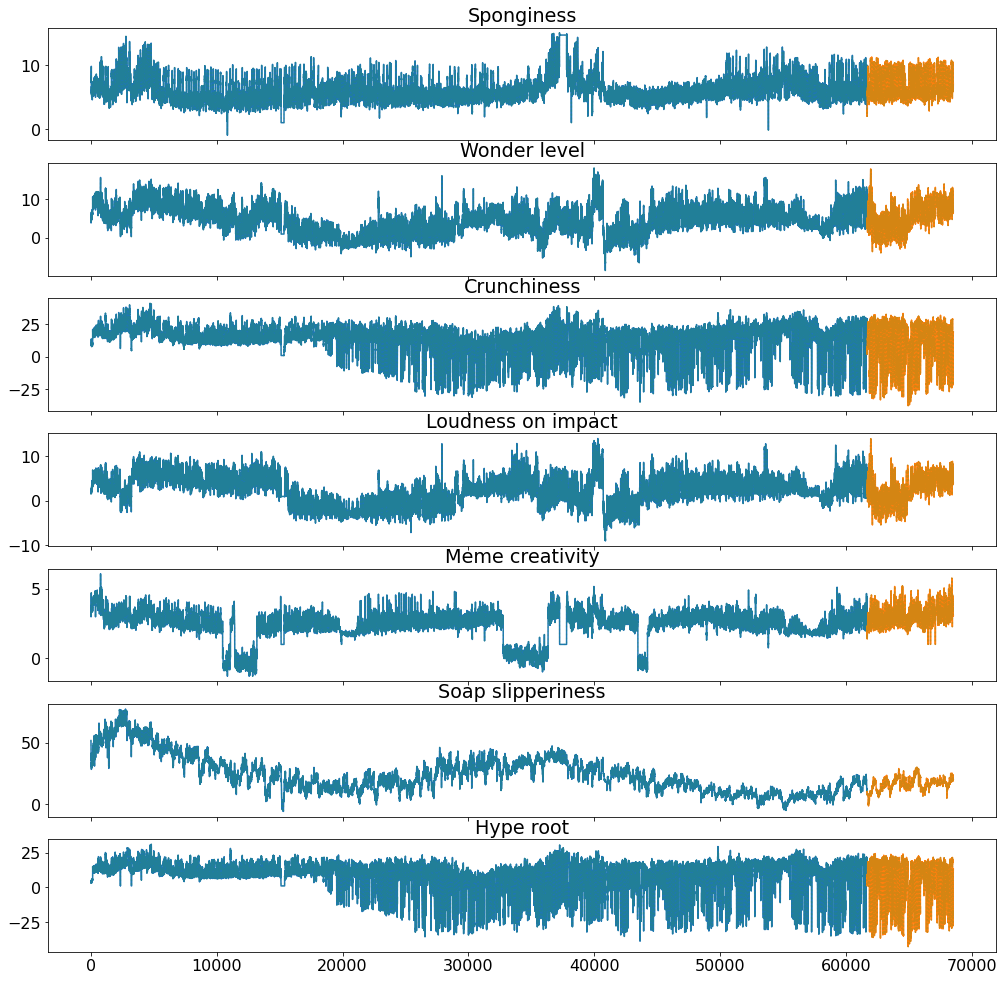

In [11]:
mmscaler = joblib.load(scaler_path)

X = mmscaler.inverse_transform(X_pp_train)
X_t = mmscaler.inverse_transform(X_pp_test)

# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting
h = np.concatenate((X,X_t))
h = pd.DataFrame(h, columns = dataset.columns)
X = h.iloc[:-test_size]
X_t = h.iloc[-test_size:]

def plot_norm_data(arr1, arr2, df, columns):
    assert arr1.shape[1] == arr2.shape[1]
    figs, axs = plt.subplots(
        arr1.shape[1],
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(arr1.iloc[:, i])
        axs[i].plot(arr2.iloc[:, i])
        axs[i].plot(df[col], linestyle = ':'  ,alpha = 0.2)
        axs[i].set_title(col)
    plt.show()
plot_norm_data(X, X_t, dataset, dataset.columns)


## Create the Sequences

In [12]:
# First objective should be to predict the next quarter of test length. You can look at the instructions for the competition for 
# more information. So the total length to predict is c_telescope = 1152. In the first part of the competition we must predict 3 
# quarters of the total test sequences, i.e. 3/4 * 1152 = 864. One single quarter is made up of 1152/4 = 288. I believe, whatever
# the final structure of the model, that we could firs predict a quarter and then recgressively predict the rest.

quarter_tel = (1152//4) #288

# We can try to predict the quarter in 4 steps of 36

reg = 4
telescope = int(quarter_tel//5) #72
assert quarter_tel%4 == 0

# target labels are all the labels
target_labels = dataset.columns

# Hyper parameters for how to build the sequences. The total length of the dataset is 68528, so quite large. I would take the
# usual length to start with. We will obtain a very large number of sequences. Note that in 
# the inspection of the data the beginning of the sequence seemed quite different from the later evolution. One could consider removing 
# the first part as a possibility. 

window = 300
stride = 10

In [13]:
# build sequence function
def build_sequences(df, target_labels=['pollution'], window=200, stride = 20, telescope=100):
    # check to avoid errrors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values #copy() makes a deep copy
    temp_labels = df[target_labels].copy().values
    need_4_padding = len(df)%window != 0
    
    if(need_4_padding):
        padding_len = window-len(df)%window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_labels.shape[1]), dtype='float64')
        temp_labels = np.concatenate((padding, temp_labels))
        assert len(temp_df)%window == 0
        
    for idx in np.arange(0, len(temp_df)-window-telescope, stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_labels[idx+window:idx+window+telescope])
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [14]:
X_train, y_train = build_sequences(
    X_pp_train,
    target_labels=target_labels,
    window=window,
    stride=stride,
    telescope=telescope
    )
X_test, y_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=window,
    stride=stride,
    telescope=telescope
    )

In [15]:
# Inspect random sequence

# plotting function 
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
       idx=np.random.randint(0,len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
        # print(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+1))
    plt.show()    

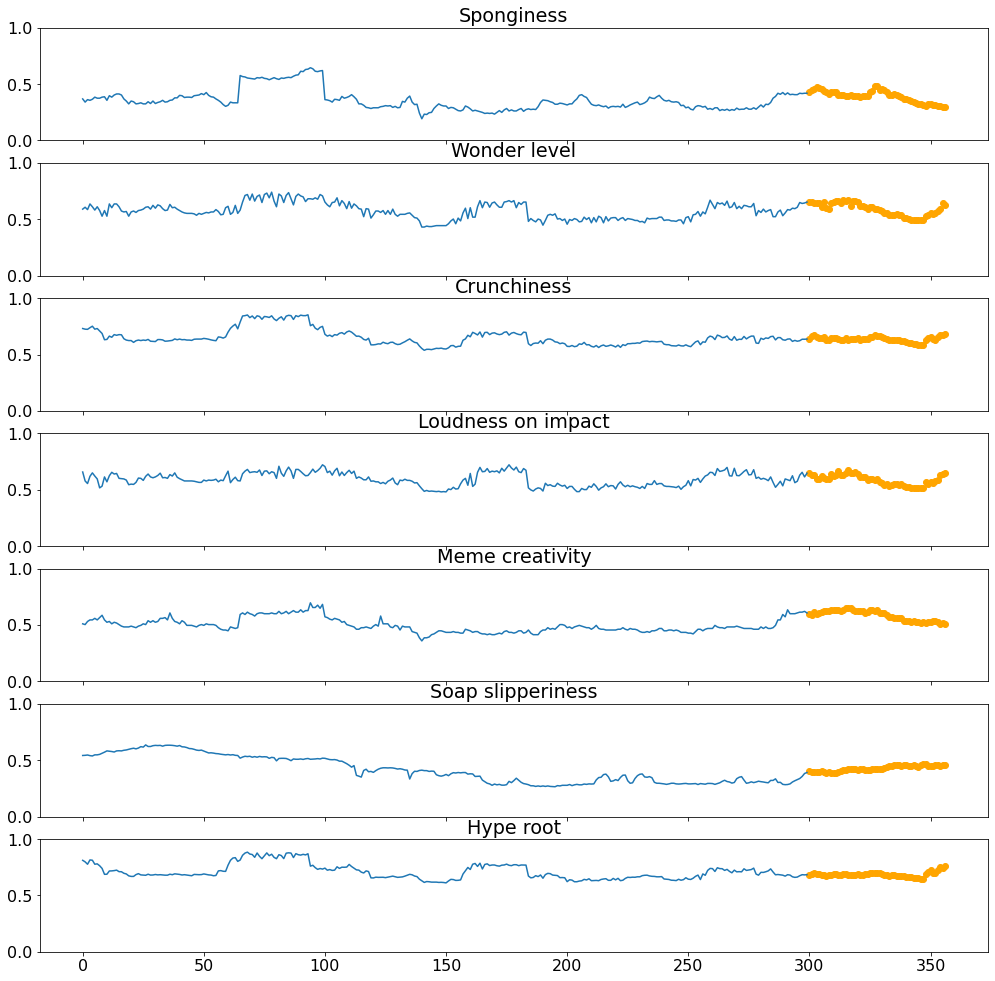

In [16]:
# inspect training sequence
inspect_multivariate(X_train, y_train, target_labels, telescope)

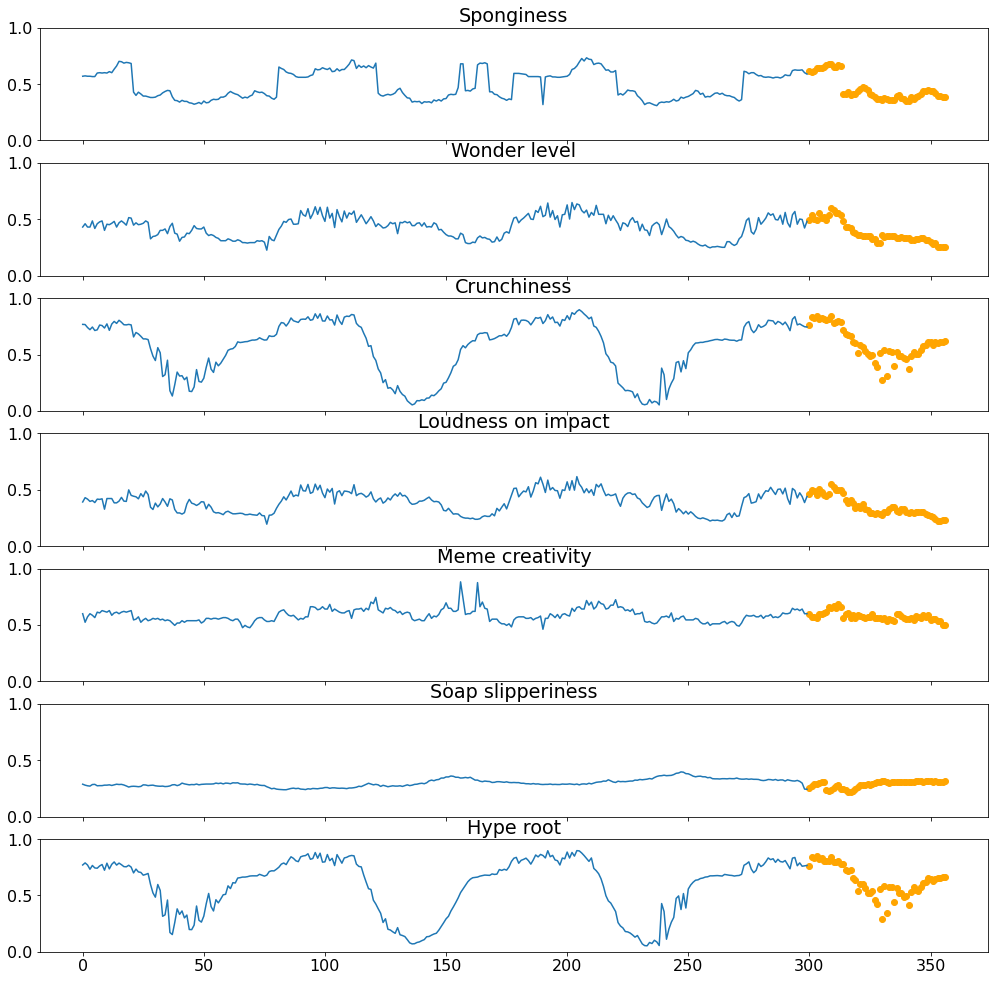

In [17]:
# inspect test sequence
inspect_multivariate(X_test, y_test, target_labels, telescope)

## Seq2Seq Architecture

In [18]:
# hyperparams

# model hyperparams
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

batch_size = 512
epochs = 200

In [19]:
# Function to create the model 
def sequence2sequence(
    num_features, input_shape, telescope
):
    # Build Encoder-Decoder Model
    # ---------------------------
    
    # ENCODER
    # -------
    encoder_input = tf.keras.Input(
        shape=input_shape, name = 'encoder_input'
    )
    
    encoder_output, h, c = tf.keras.layers.LSTM(
        units=128, return_state=True, 
        name = 'encoder_lstm'
    )(encoder_input)
    
    # Note we are setting return sequence = True
    # Cell state: Long term memory of the model, only part of LSTM models
    # Hidden state: Working memory, part of LSTM and RNN models
    # return_sequence -> LSTM returns: all hidden states:
    # h_(t-n),..., h_t
    # return_state -> LSTM returns: cell state + hidden state at time t
    # h_t, h_t, c_t
    # both return state and return state:
    # [h_(t-n),..., h_t], h_t, c_t
    # neither return state, return sequence:
    # h_t
    
    # save encoder state (to intialize the decoder) 
    
    encoder_state = [h, c] 
    
    # note that both h and c are passed to the decoder to initialize the state
    # this is why we needed return_state = True
    
    #DECODER
    #-------
    decoder_input = tfkl.RepeatVector(telescope)(encoder_output)
    # initialize the decoder state with the final encoder state
    decoder_lstm = tf.keras.layers.LSTM(
        units=128, 
        return_sequences=True,
        name='decoder_lstm'
    )(decoder_input, initial_state = encoder_state)
    # note that we are not simply returning the last state, but the whole
    # sequence. Indeed, we want the decoder to predict all the words in the 
    # sentence. So the output of the dence layer will be 
    # (batch_size, max_sequence_lenght-1[i.e. SOS], vocabulary_size +1[i.e. 0 for padding])
    
    
    decoder_out = tf.keras.layers.Dense(
        num_features, # +1 because the output of decoder includes EOS
        activation='relu',
        name = 'decoder_out'
    )(decoder_lstm)
    
    #MODEL 
    model = tf.keras.Model(encoder_input, decoder_out)
    
    #---------------
    # compile training model
    model.compile(
        loss=tfk.losses.MeanSquaredError(), 
        # so we don't have to use 1-hot encoding
        optimizer = tfk.optimizers.Adam(learning_rate = 1e-2),
        # large learning rate, probably because the net is simple and 
        # it takes a long time to train 1 epoch
        metrics = ['mae']
    )
    
    return model, encoder_state

In [20]:
seq2seq_model, encoder_state = sequence2sequence(
    num_features=7, input_shape=input_shape, telescope = telescope
)

seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 300, 7)]     0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 128),        69632       ['encoder_input[0][0]']          
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 57, 128)      0           ['encoder_lstm[0][0]']           
                                                                                              

In [21]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#train the RNN
history = seq2seq_model.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=5,
            restore_best_weights=True
            ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            patience=5,
            factor=0.5,
            min_lr=1e-5
            ),
        ]
    ).history

Epoch 1/200
11/11 [==============================] - 5s 236ms/step - loss: 0.3052 - mae: 0.4292 - val_loss: 0.1337 - val_mae: 0.3051 - lr: 0.0100
Epoch 2/200
11/11 [==============================] - 2s 185ms/step - loss: 0.1159 - mae: 0.2659 - val_loss: 0.1256 - val_mae: 0.2885 - lr: 0.0100
Epoch 3/200
11/11 [==============================] - 2s 188ms/step - loss: 0.1125 - mae: 0.2540 - val_loss: 0.1208 - val_mae: 0.2710 - lr: 0.0100
Epoch 4/200
11/11 [==============================] - 2s 186ms/step - loss: 0.1114 - mae: 0.2486 - val_loss: 0.1201 - val_mae: 0.2701 - lr: 0.0100
Epoch 5/200
11/11 [==============================] - 2s 187ms/step - loss: 0.1111 - mae: 0.2474 - val_loss: 0.1201 - val_mae: 0.2688 - lr: 0.0100
Epoch 6/200
11/11 [==============================] - 2s 186ms/step - loss: 0.1109 - mae: 0.2466 - val_loss: 0.1198 - val_mae: 0.2686 - lr: 0.0100
Epoch 7/200
11/11 [==============================] - 2s 185ms/step - loss: 0.1107 - mae: 0.2459 - val_loss: 0.1193 - val_mae

Epoch 57/200
11/11 [==============================] - 2s 185ms/step - loss: 0.0076 - mae: 0.0627 - val_loss: 0.0113 - val_mae: 0.0730 - lr: 0.0100
Epoch 58/200
11/11 [==============================] - 2s 185ms/step - loss: 0.0074 - mae: 0.0617 - val_loss: 0.0120 - val_mae: 0.0723 - lr: 0.0100
Epoch 59/200
11/11 [==============================] - 2s 183ms/step - loss: 0.0071 - mae: 0.0606 - val_loss: 0.0116 - val_mae: 0.0749 - lr: 0.0100
Epoch 60/200
11/11 [==============================] - 2s 185ms/step - loss: 0.0073 - mae: 0.0613 - val_loss: 0.0108 - val_mae: 0.0718 - lr: 0.01000.0073 - mae: 0.0
Epoch 61/200
11/11 [==============================] - 2s 185ms/step - loss: 0.0065 - mae: 0.0590 - val_loss: 0.0111 - val_mae: 0.0728 - lr: 0.0100
Epoch 62/200
11/11 [==============================] - 2s 187ms/step - loss: 0.0064 - mae: 0.0576 - val_loss: 0.0098 - val_mae: 0.0693 - lr: 0.0100
Epoch 63/200
11/11 [==============================] - 2s 187ms/step - loss: 0.0060 - mae: 0.0560 - va

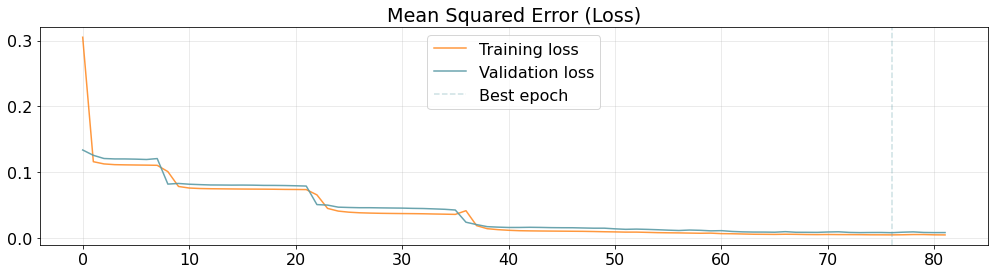

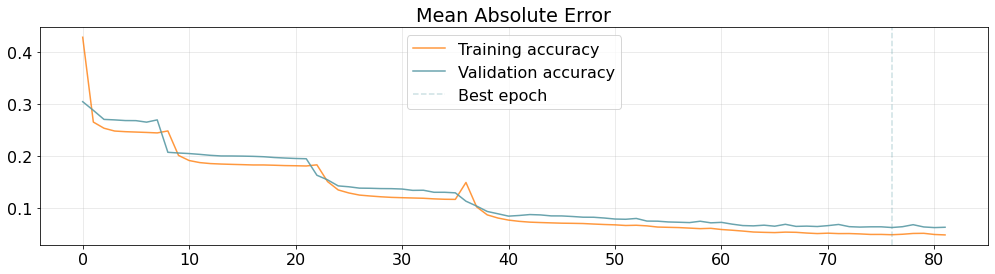

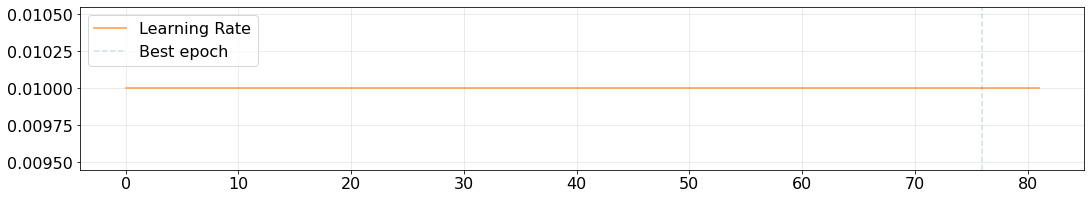

In [22]:
# plot the training

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [65]:
# save the model

models_dir = 'models'
modelname = 'seq2seq_base2'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

seq2seq_model.save(os.path.join(models_dir, modelname))

In [24]:
del seq2seq_model

## Evaluate Performance

In [25]:
seq2seq_model = tfk.models.load_model(os.path.join(models_dir, 'seq2seq_base2'))

# predict the test set
predictions = seq2seq_model.predict(X_test)

# calculate mean errors
mean_squared_error = tfk.metrics.mse(y_test.flatten(), predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(), predictions.flatten())

mean_absolute_error, mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.06659529>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008667951>)

In [26]:
## inspect the performance of the model

def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

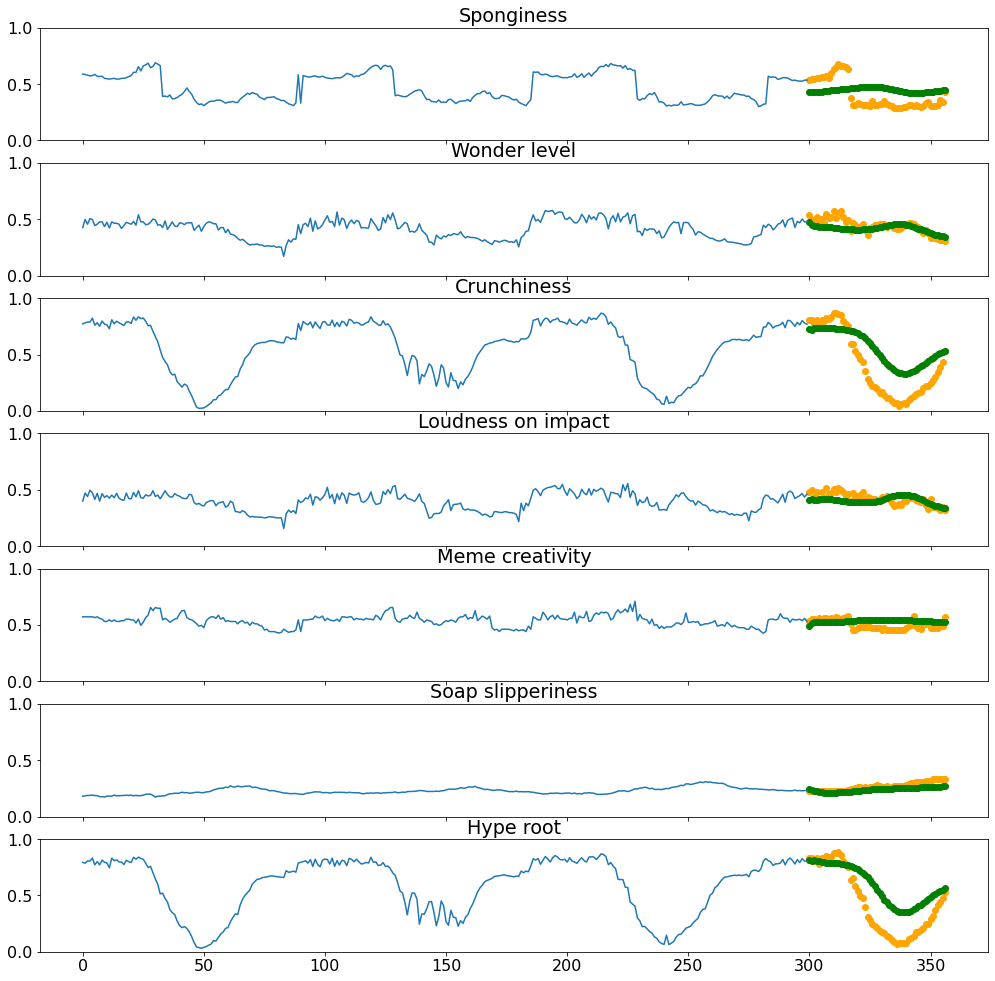

In [27]:
inspect_multivariate_prediction(
    X_test, 
    y_test, 
    predictions, 
    columns=target_labels, 
    telescope=telescope
)

### Compare with other models 

model1 = tfk.models.load_model(os.path.join(models_dir, 'model72'))

# predict the test set
predictions1 = model1.predict(X_test)

# calculate mean errors
mean_squared_error = tfk.metrics.mse(y_test.flatten(), predictions1.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(), predictions1.flatten())

mean_absolute_error, mean_squared_error

## inspect the performance of the model

def compare_multivariate_prediction(X, y, pred1, pred2, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx, :, i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred1[idx,:,i], color='green')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred2[idx,:,i], color='red')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()


compare_multivariate_prediction(
    X_test, 
    y_test, 
    predictions,
    predictions1,
    columns=target_labels, 
    telescope=telescope
)

## 3 quarters prediction

In [28]:
# sbm_tel = 864

X_test_reg, y_test_reg = build_sequences(
    X_pp_test, 
    target_labels, 
    window, 
    stride, 
    sbm_telescope)

In [29]:
def regressive_predict(model, size, X_temp_in, telescope):
    predictions= np.array([])
    X_temp = X_temp_in
    for reg in range(0,size,telescope):
        pred_temp = model.predict(X_temp)
        if(len(predictions)==0):
            predictions = pred_temp
        else:
            predictions = np.concatenate((predictions, pred_temp), axis=1)
        X_temp = np.concatenate((X_temp[:, telescope: , :], pred_temp), axis=1)
        #this way X_temp always has the same shape
    return predictions 

In [30]:
predictions = regressive_predict(seq2seq_model, sbm_telescope, X_test_reg, telescope)

In [40]:
predictions = predictions[:, :y_test_reg.shape[1], :]

In [39]:
y_test_reg.shape

(574, 864, 7)

In [42]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = [] # future mean abs error -> each step
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:, i, j]-predictions[:, i, j])))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

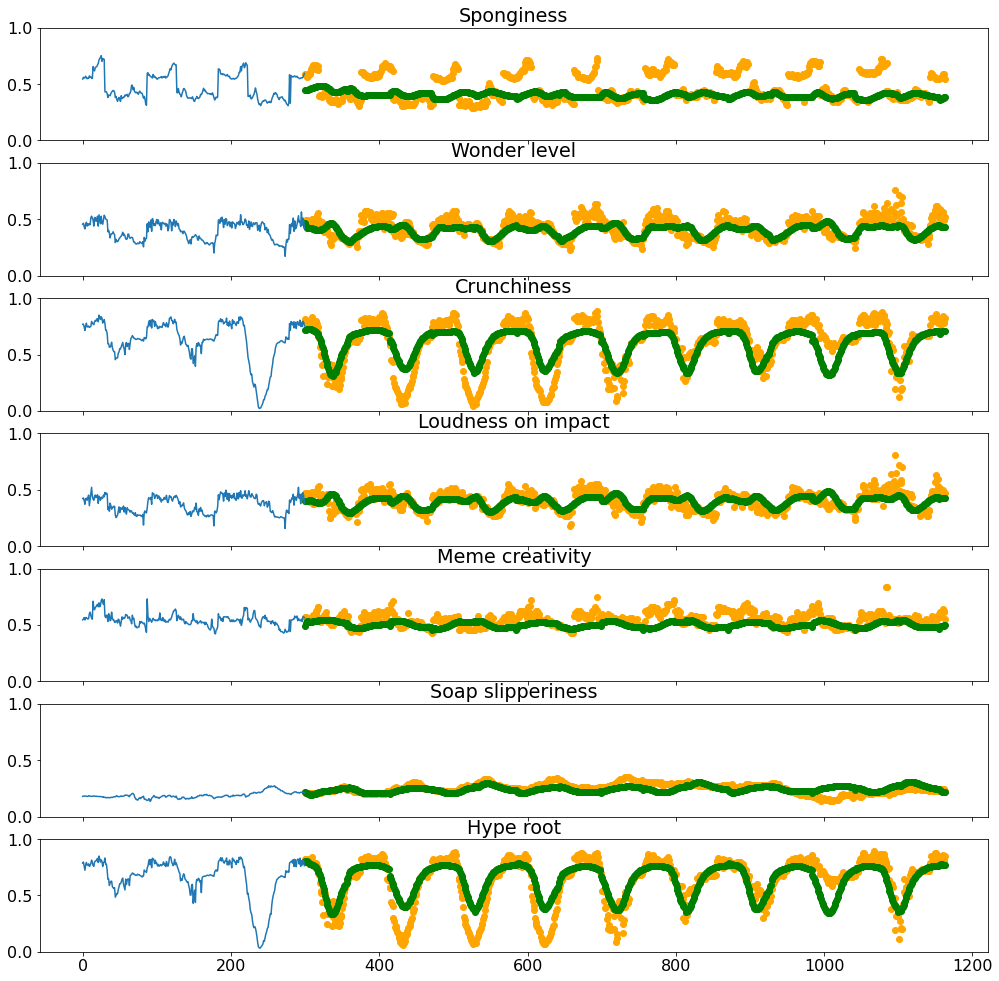

In [61]:
inspect_multivariate_prediction(
    X_test_reg, 
    y_test_reg, 
    predictions, 
    columns=target_labels, 
    telescope=sbm_telescope
)

In [62]:
## inspect the performance of the model

def inspect_multivariate_prediction_mae(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx, :, i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].fill_between(
            np.arange(len(X[0,:,i]), len(X[0,:,i])+ telescope), 
            y[idx,:,i]+maes[:,i], 
            y[idx,:,i]-maes[:,i], 
            color='orange', alpha=.3
        )
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [58]:
maes.shape, y_test_reg.shape

((864, 7), (574, 864, 7))

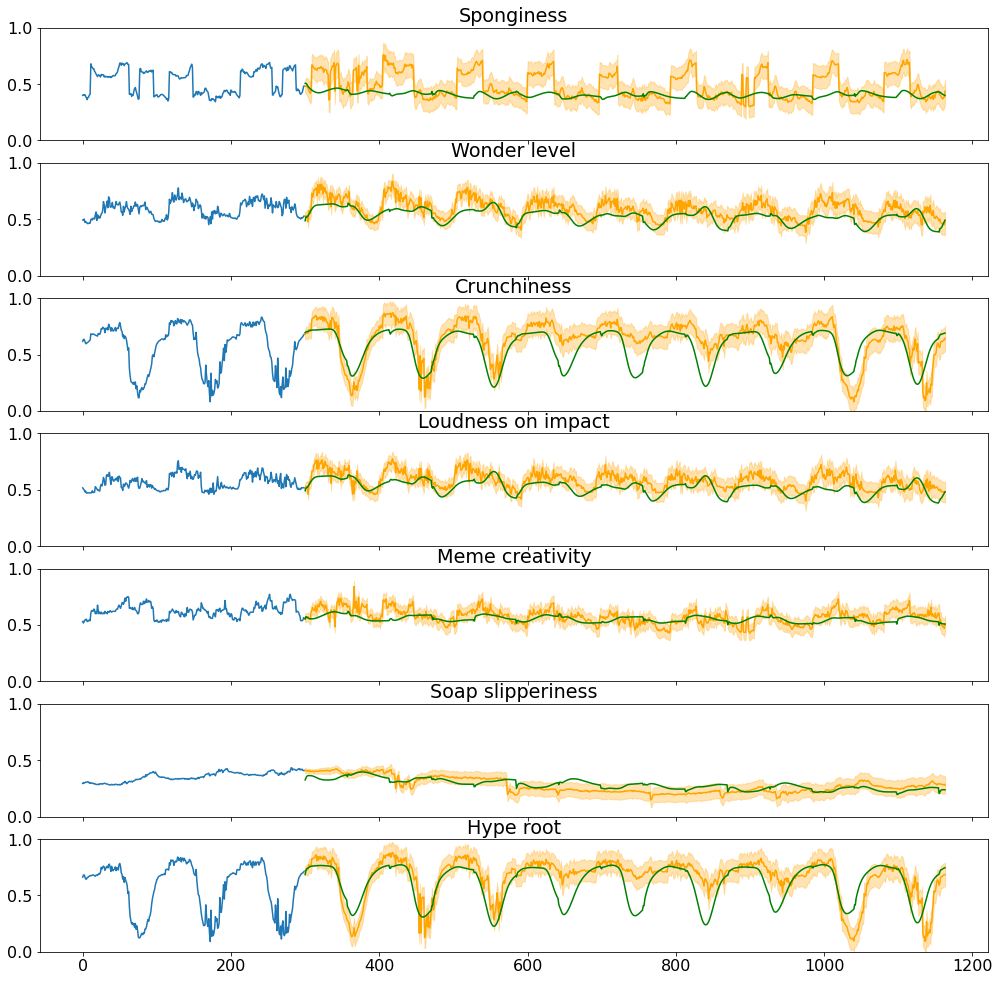

In [63]:
inspect_multivariate_prediction_mae(
    X_test_reg, 
    y_test_reg, 
    predictions, 
    columns=target_labels, 
    telescope=sbm_telescope
)

In [70]:
# calculate mean errors
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(), predictions.flatten()).numpy()
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(), predictions.flatten()).numpy()

mean_absolute_error, mean_squared_error

(0.08278284, 0.012079355)

In [73]:
import json
eval_dir = 'vars'

scores = {
    'mse': str(mean_squared_error),
    'mae': str(mean_absolute_error)
}

if not os.path.exists(os.path.join(eval_dir, 'scores.json')):
    with open(os.path.join(eval_dir, 'scores.json'), 'w') as f:
        json.dump({modelname: scores}, f)
else:
    with open(os.path.join(eval_dir, 'scores.json'), 'r') as f:
        all_scores = json.load(f)
        print(all_scores)
        all_scores[modelname] = scores
    with open(os.path.join(eval_dir, 'scores.json'), 'w') as f:
        print(all_scores)
        json.dump(all_scores, f)

plt.show()

{}
{'seq2seq_base2': {'mse': '0.012079355', 'mae': '0.08278284'}}
